In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
import matplotlib.pylab as plt


agg_match_db = create_engine('sqlite:///agg_match.db')
df = pd.read_sql_query('select match_id, player_kills, player_dbno, player_assists, total_dist, team_placement from amatch_solo where total_dist < 8400 and team_placement < 70 and match_id != "2U4GBNA0Ymk3A8MeEZ-PNg1-qukaDA-0V1iS3D595Eq57-uRbBGnLpYfN0X8eWRB"order by match_id', agg_match_db)
df['skill'] = df['player_kills']+df['player_dbno']+0.5*df['player_assists']

In [2]:
df1 = df[['match_id', 'skill', 'total_dist', 'team_placement']]
df1 = df1.reset_index(drop=True)

In [3]:
ids = df1['match_id']
pre_id = ids[0]
dist_sum = 0
skill_sum = 0
res = []
match_len = len(ids)
dist = df1['total_dist']
skill = df1['skill']
player_num = 0
print(match_len)
for i in range(match_len):
    current_id = ids[i]
    if(i == match_len-1):
        player_num += 1
        dist_sum += dist[i].round(4)
        skill_sum += skill[i]
        res.append((pre_id, dist_sum, skill_sum, player_num))
    else:
        if(current_id == pre_id):
            player_num += 1
            dist_sum += dist[i].round(4)
            skill_sum += skill[i]
        else:
            res.append((pre_id, dist_sum, skill_sum, player_num))
            pre_id = current_id
            dist_sum = dist[i].round(4)
            skill_sum = skill[i]
            player_num += 1

10010748


In [4]:
df2 = df1
df2.tail(10)

,match_id,skill,total_dist,team_placement
10010738,2U4GBNA0YmnzzzHg0kBZkiu-j3NdC-664BMKNZtR6JUSVN...,1.0,1819.675780,20
10010739,2U4GBNA0YmnzzzHg0kBZkiu-j3NdC-664BMKNZtR6JUSVN...,1.0,4280.980962,16
10010740,2U4GBNA0YmnzzzHg0kBZkiu-j3NdC-664BMKNZtR6JUSVN...,0.0,2627.601012,68
10010741,2U4GBNA0YmnzzzHg0kBZkiu-j3NdC-664BMKNZtR6JUSVN...,0.0,227.331558,65
10010742,2U4GBNA0YmnzzzHg0kBZkiu-j3NdC-664BMKNZtR6JUSVN...,0.0,2246.812530,33
10010743,2U4GBNA0YmnzzzHg0kBZkiu-j3NdC-664BMKNZtR6JUSVN...,8.0,7026.564740,1
10010744,2U4GBNA0YmnzzzHg0kBZkiu-j3NdC-664BMKNZtR6JUSVN...,0.0,1505.925780,41
10010745,2U4GBNA0YmnzzzHg0kBZkiu-j3NdC-664BMKNZtR6JUSVN...,0.0,723.772034,44
10010746,2U4GBNA0YmnzzzHg0kBZkiu-j3NdC-664BMKNZtR6JUSVN...,0.0,2647.524440,39
10010747,2U4GBNA0YmnzzzHg0kBZkiu-j3NdC-664BMKNZtR6JUSVN...,0.0,2817.394780,40


In [5]:
print(res[-2][0],res[-1][0],res[0][0])

2U4GBNA0Ymnzzz2yBDDobKwFNTU41g6U1FYjtGGaE5oIRpvyLw8iM2KfOkR7jute 2U4GBNA0YmnzzzHg0kBZkiu-j3NdC-664BMKNZtR6JUSVN1OdpVGZwAlUBssv5HJ 2U4GBNA0Ymk--2xnuFhXM2XOTQ1-vT4JaSt5qsPdeJimOjvddCBiTumAcdw1lXFT


In [6]:
import time
start = time.time()
dist = []
skill = []
player_nums = res[:][3]
print(len(player_nums))
pre_index = 0
for i in player_nums:
        for j in range(pre_index, i):
            dist.append(100*df2.loc[j, 'total_dist']/player_nums[j])
            skill.append(100*df2.loc[j, 'skill']/player_nums[j])
        pre_index = i

df2['norm_dist'] = pd.DataFrame(dist)
df2['norm_skill'] = pd.DataFrame(skill)
end = time.time()
print(end-start)

4


TypeError: 'str' object cannot be interpreted as an integer

In [7]:
state = 0
import time
start = time.time()
dist = []
skill = []
match_len = len(df2['match_id'])
current_id = res[0][0]
for i in range(match_len):
    if df2.loc[i, 'match_id'] == current_id:
        dist.append(100*df2.loc[i, 'total_dist']/np.round(res[state][1],4))
        skill.append(100*df2.loc[i, 'skill']/np.round(res[state][2],4))
    else:
        state += 1
        current_id = res[state][0]
        dist.append(100*df2.loc[i, 'total_dist']/np.round(res[state][1],4))
        skill.append(100*df2.loc[i, 'skill']/np.round(res[state][2],4))

df2['norm_dist'] = pd.DataFrame(dist)
df2['norm_skill'] = pd.DataFrame(skill)
end = time.time()
print(end-start)

1286.4166765213013


In [8]:
df2['score'] = 10*df2['norm_dist']+10*df2['norm_skill']

In [9]:
df3 = df2[['norm_dist', 'norm_skill']]
df3_m = df3.as_matrix()

In [10]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df3_m)
y_kmeans = kmeans.predict(df3_m)

In [11]:
df2['cluster'] = y_kmeans

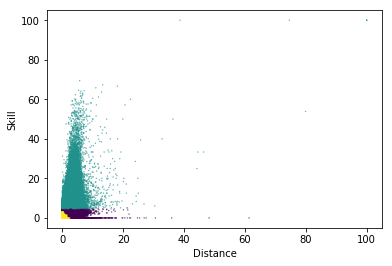

In [23]:
plt.scatter(df3['norm_dist'], df3['norm_skill'], c = y_kmeans, s=0.1, cmap='viridis')
plt.xlabel("Distance")
plt.ylabel("Skill")
plt.show()

In [ ]:
#noise in our data
#df5 = df1[df1.match_id == "2U4GBNA0Ymk3A8MeEZ-PNg1-qukaDA-0V1iS3D595Eq57-uRbBGnLpYfN0X8eWRB"]
#df5

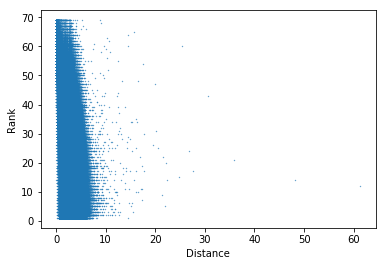

In [24]:
df6 = df2[['norm_dist', 'team_placement', 'cluster', 'norm_skill']]
df7 = df6[df6.cluster == 0]
plt.scatter(df7['norm_dist'], df7['team_placement'], s=0.1, cmap='viridis')
plt.xlabel("Distance")
plt.ylabel("Rank")
plt.show()

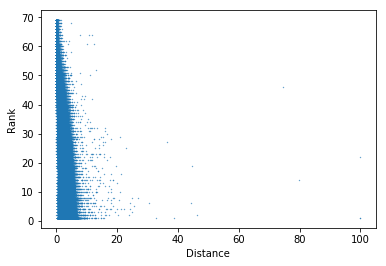

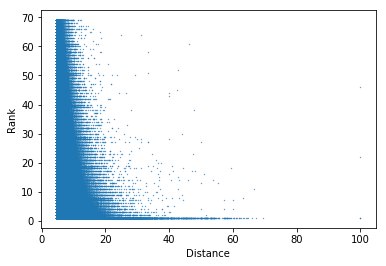

In [22]:
df8 = df6[df6.cluster == 1]
plt.scatter(df8['norm_dist'], df8['team_placement'], s=0.1, cmap='viridis')
plt.xlabel("Distance")
plt.ylabel("Rank")
plt.show()
plt.scatter(df8['norm_skill'], df8['team_placement'], s=0.1, cmap='viridis')
plt.xlabel("Distance")
plt.ylabel("Rank")
plt.show()

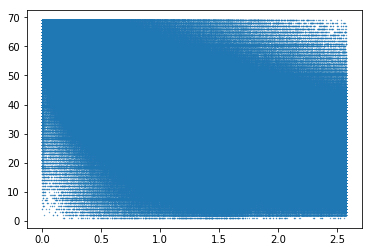

In [15]:
df9 = df6[df6.cluster == 2]
plt.scatter(df9['norm_dist'], df9['team_placement'], s=0.1, cmap='viridis')
plt.show()